In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import defaultdict

class Portfolio():
    def __init__(self,syms,sym_data):
        self.syms = syms
        self.sym_data = sym_data

class QTrader(object):
    def __init__(self, sym_data, eta=1, transaction_cost=0.005, position=10):
        self.sym_data = sym_data
        self.stock_data = sym_data#pd.merge(pd.read_csv('./tbill.csv', index_col='Date'), pd.read_csv('./^GSPC.csv', index_col='Date'), right_index=True, left_index=True).sort_index()
        ret = self.stock_data['Close'].rolling(window=2, center=False).apply(lambda x: x[1] / x[0] - 1)
        # These are price returns and the weekly returns for TBills (3 months)self.stock_data['Close']
        self.returns = pd.DataFrame({
                                        'stocks': self.stock_data['Close'].rolling(window=2, center=False).apply(lambda x: x[1] / x[0] - 1),
                                        'tbills': (ret.std()) ,
                                    }, index=self.stock_data.index)

        self.returns['risk_adjusted'] = (self.returns.stocks - self.returns.tbills)
        self.returns['risk_adjusted_moving'] = self.returns.risk_adjusted.rolling(window=12).apply(lambda x: x.mean())
        self.returns['risk_adjusted_stdev'] = self.returns.risk_adjusted.rolling(window=12).apply(lambda x: x.std())
        self.returns['risk_adjusted_high'] = self.returns.risk_adjusted_moving + 1.5 * self.returns.risk_adjusted_stdev
        self.returns['risk_adjusted_low'] = self.returns.risk_adjusted_moving - 1.5 * self.returns.risk_adjusted_stdev
        self.returns['state'] = (self.returns.risk_adjusted > self.returns.risk_adjusted_high).astype('int') - \
                                (self.returns.risk_adjusted < self.returns.risk_adjusted_high).astype('int') # pd.qcut(self.returns.sharpe_moving, 10, labels=range(10))
    def graph_portfolios(self):

        midpoint = int(len(self.returns.index) / 2)
        training_indexes = self.returns.index[:midpoint] 
        testing_indexes = self.returns.index[midpoint:]

        portfolios = pd.DataFrame({
            'buy_and_hold': self.buy_and_hold(testing_indexes),
            'buy_tbills': self.buy_tbills(testing_indexes),
            'random': self.random(testing_indexes),
            'qtrader': self.q_holdings(training_indexes, testing_indexes)
            }, index=testing_indexes)

        portfolio_values = pd.DataFrame({
                'buy_and_hold': self.evaluate(portfolios.buy_and_hold),
                'buy_tbills': self.evaluate(portfolios.buy_tbills),
                'random': self.evaluate(portfolios.random),
                'qtrader': self.evaluate(portfolios.qtrader)
            }, index=testing_indexes)
        
        portfolio_values.plot()

        plt.annotate("Buy and hold sharpe: {}\n QTrader sharpe: {}".format(self.sharpe(portfolios.buy_and_hold), self.sharpe(portfolios.qtrader)), xy=(0.25, 0.95), xycoords='axes fraction')
        
        plt.show()
        
    def buy_and_hold(self, dates):
        return pd.Series(1, index=dates)

    def buy_tbills(self, dates):
        return pd.Series(0, index=dates)

    # This will go long or short or do nothing randomly
    def random(self, dates):
        return pd.Series(np.random.randint(-1, 2, size=len(dates)), index=dates)

    def calc_returns(self, holdings):
        return pd.Series(self.returns.tbills + holdings * self.returns.risk_adjusted, index=holdings.index)

    def evaluate(self, holdings):
        return (self.calc_returns(holdings) + 1).cumprod()

    def state(self, first_moment, second_moment):
        return first_moment + second_moment * 10

    def q_holdings(self, training_indexes, testing_indexes):
        factors = pd.DataFrame({'action': 0, 'reward': 0, 'state': 0}, index=training_indexes)

        # Initialize Q matrix
        q = {0: {1:0, 0:0, -1:0}}
        
        # For Dyna-Q
        T = np.zeros((3, 3, 3)) + 0.00001
        R = np.zeros((3,3))

        # Episodes
        for i in range(100):
            last_row, last_date = None, None

            for date, row in factors.iterrows():
                return_data = self.returns.loc[date]
                if return_data.state not in q:
                    q[return_data.state] = {1: 0, 0:0, -1:0}

                if last_row is None or np.isnan(return_data.state):
                    state = 0
                    reward = 0
                    action = 0
                else:
                    state = int(return_data.state)
                    if random.random() > 0.001:
                        action = max(q[state], key=q[state].get)
                    else:
                        action = random.randint(-1,1)

                    reward = last_row.action * (return_data.stocks - return_data.tbills)

                    alpha = 1
                    discount = 0.9

                    factors.loc[date, 'reward'] = reward
                    factors.loc[date, 'action'] = action
                    factors.loc[date, 'state'] = return_data.state

                    update = alpha * (factors.loc[date, 'reward'] + discount * max(q[row.state].values()) - q[state][action])
                    if not np.isnan(update):
                        q[state][action] += update

                    # Dyna
                    action_idx = int(last_row.action+1)
                    state_idx = int(last_row.state+1)
                    new_state_idx = int(state+1)

                    T[state_idx][action_idx][new_state_idx] += 1
                    R[state_idx][action_idx] = (1 - alpha) * R[state_idx][action_idx] + alpha * reward

                last_date, last_row = date, factors.loc[date]

            for j in range(100):
                state_idx = random.randint(0,2)
                action_idx = random.randint(0,2)
                new_state = np.random.choice([-1, 0, 1], 1, p=T[state_idx][action_idx]/T[state_idx][action_idx].sum())[0]
                r = R[state_idx][action_idx]
                q[state][action] += alpha * (r + discount * max(q[new_state].values()) - q[state][action])

            sharpe = self.sharpe(factors.action)

            if sharpe > 0.20:
                break
            #print("For episode {} we get an internal sharpe ratio of {}".format(i, self.sharpe(factors.action)))

        testing = pd.DataFrame({'action': 0, 'state': 0}, index=testing_indexes)
        testing['state'] = self.returns.loc[testing_indexes, 'state']
        testing['action'] = testing['state'].apply(lambda state: max(q[state], key=q[state].get))

        print(self.sharpe(testing.action))

        return testing.action

    def discretize(self, number, steps):
        return 0

    def sharpe(self, holdings):
        returns = holdings * (self.returns.stocks - self.returns.tbills)

        return np.nanmean(returns) / np.nanstd(returns)

    


In [3]:

import datetime
from time import sleep
from binance.client import Client
import pandas as pd
import datetime
import time
import numpy as np
import os
import sys
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from statsmodels.tsa.stattools import coint

#from crontab import CronTab
from safe_schedule import SafeScheduler
#add your api keys here
api_key = 'XuozVlFg2WYVemwmHMqCK9j5jSYIV1z3MoDAXY76X2JiCbbgcw7dGxvE0eGVsqhH'
secret_key = 'WyWBCdczLCFvV8fKy16R5dOwhhjK31T7ZrW0cplIzjrvmlSPh5E1KEeAEh5c9I6s'

#Open location of recorded buy/sell walls
bw_location = '/home/me/Documents/BWA/data/watcher/buywalls/'
sw_location = '/home/me/Documents/BWA/data/watcher/sellwalls/'
save_port = '/githome/me/Documents/BWA/data/bw_portfolios'

#Open binance client
client = Client(api_key, secret_key)

#get current time and format to compare with data
current_milli_time = lambda: int(round(time.time() * 1000))


def get_data(sym,prev_k,k,candle_k='5m'):
    """
    Function downloads hist data from binance API with given timestamps
    """
    #previous kline interval
    prev_k = str(prev_k)
    #current kline interval
    k = str(k)
    #download historical data
    data = client.get_historical_klines(sym,interval= candle_k,start_str =int(prev_k),end_str = int(k))
    data = pd.DataFrame(data,columns=['Open time','Open','High','Low','Close','Volume','Close time','Quote volume','Num trades', 'btc buys', 'coin buys', 'ignore'])
    
    # convert from millesecond time to datetime for potential resampling and readability
    data['Open time'] = data['Open time']/1000
    data['Open time'] = data['Open time'].astype('datetime64[s]')
    data = data.set_index('Open time')
    data = data[['Open','High','Low','Close','Close time','Volume']].astype(float)
    return data

def to_dt(v,is_milli=True):
    """
    Function to convert timestamp to datetime object
    has parameter for millisecond uts timestamp
    """
    if(is_milli):
        v = datetime.datetime.fromtimestamp(int(v)/1000)
    else:
        v = datetime.datetime.fromtimestamp(int(v))
    return v

def get_freq_sig(loc):
    """
    Function loads all signal csv files and concatenates them into a signle dataframe
    """
    # cd cmd
    os.chdir(bw_location)
    #sorting by file creation (could use normal sort as filenames are timestamps)
    files = filter(os.path.isfile,os.listdir(bw_location))
    files =  [int(f) for f in files]
    files = list(files)
    #Create frequency signal dataframe
    fs_df = pd.DataFrame(files)
    #sort again
    fs_df = fs_df[0].sort_values()
    #starttime,endtime
    st,end = to_dt(fs_df.iloc[0]),to_dt(fs_df.iloc[-1])
    bw_freq = []
    
    f_len = int(len(os.listdir(loc)))
    for c,i in enumerate(os.listdir(loc)):
        try:
            curr = pd.read_csv(loc+i)
        except Exception as e:
            print(i,e)
 
        curr.columns = ['Coin','Close','Profit','Loss','Date']  
        bw_freq.append(curr)
        if((c/f_len)%10==0):
            pct = str(int((c/f_len)*100))
            print("{}% of files loaded".format(pct))
    bw_freq = pd.concat(bw_freq)
    bw_freq = bw_freq[['Date','Coin','Close']]
    bw_freq.columns = ['Date','Coin','Close']
    bw_freq = bw_freq.sort_values(['Date'],ascending=False)
    #print(all_w.head(), len(all_w))
    #bw_freq['all_freq'] = bw_freq.groupby('Coin')['Coin'].transform('count')
    #bw_freq = bw_freq.sort_values(['Date'],ascending=False)    
    print(st,end)
    print(to_dt(now), now)
    print(fs_df.head())
    return bw_freq

def clean_fs(fs):
    """
    Function to clean frequency signal dataframe
    """
    fs =fs.drop_duplicates()
    fs = fs.sort_values(['Date'],axis=0)
    fs['Date_m'] = fs['Date']
    fs['Date'] = fs['Date']/1000
    fs['Date'] = fs['Date'].astype('datetime64[s]')

    rolling_f = {}
    f_col = []
    """
    for i in fs.iterrows():
        coin = i[1][1]
        if(coin in rolling_f.keys()):
            rolling_f[coin] += 1
            f_col.append(rolling_f[coin])
        else:
            rolling_f[coin] = 1
            f_col.append(rolling_f[coin])
    print(len(fs),len(f_col))
    fs['rolling_freq'] = f_col
    """    
    return fs



def unix_time_millis(dt):
    """
    Function to convert unix time to millesecond
    """
    epoch = datetime.datetime.utcfromtimestamp(0)
    return (dt - epoch).total_seconds() * 1000.0



def interval(intv,st,end):
    """
    Function to resample frequency dataframe to specified frequency
    
    """
    intv_list = []
    out = pd.DataFrame()
    prev = st
    while(prev<end):
        curr = prev+int(86400000*intv)
        n = to_dt(curr).strftime('%Y-%m-%d')
        p = to_dt(prev).strftime('%Y-%m-%d')
        
        print(p,"  |  ",n)
        
        prev = curr
        p = datetime.datetime.strptime(p, '%Y-%m-%d')
        n = datetime.datetime.strptime(n, '%Y-%m-%d')
        intv_list.append(p)
        data = fs_c.loc[p:n]
        #print(data.sort_values('rolling_freq',ascending=False))
        out = pd.concat([out,data],axis=0)
        
    return out.sort_index(),intv_list
    #files.sort(key=lambda x: os.path.getmtime(x))


# Generate portfolios

In [5]:

def intv_port(freq_df,intv):
    dates = freq_df.index.get_level_values('Date').drop_duplicates()
    coins = freq_df.index.get_level_values('Coin')
    date_int = pd.DataFrame({"Date":[d.strftime('%Y-%m-%d') for d in dates]})
    date_int = date_int.drop_duplicates()
    date_int = date_int.astype('datetime64[s]')
    intv_dates = list(date_int.Date[::intv])
    port = pd.DataFrame()
    for c,day in enumerate(intv_dates):
        try:
            st,end = day,intv_dates[c+1]
            print(st,end)
            curr = freq_df.loc[st:end].reset_index()
            curr['Date'] = end

        except Exception as e:
            #print(e)
            break

        curr['all_freq'] = curr.groupby('Coin')['Coin'].transform('count')
        curr = curr[['Date','Coin','Close','all_freq']].sort_values("all_freq",ascending=False)
        curr = curr.sort_values(['Date'],ascending=False)
        curr = curr.set_index('Date')
        port_coins = curr.Coin.drop_duplicates()
        c_group = curr.groupby('Coin')
        curr_port = pd.DataFrame()
        for pc in port_coins:
            curr = c_group.get_group(pc).head(1)
            curr_port = pd.concat([curr_port,curr])
            curr_port = curr_port.sort_values("all_freq",ascending=False).head(9)
        port = pd.concat([port,curr_port])

    port = port.reset_index()
    port['Date'] = port['Date'].astype('datetime64[s]')
    #print(port['Date'])
    d2 = [d.strftime('%Y-%m-%d') for d in port.Date]
    port['Date'] = d2
    port = port.set_index(['Date','Coin'])
    return port

#get freq. signal df
freq_loc = '/home/me/Documents/BWA/data/freq_concat.csv'
fs = pd.read_csv(freq_loc)
#clean freq. signal df
fs_c = clean_fs(fs)
#multilevel indexing for interval tracking
fs_c = fs_c.set_index(['Date','Coin'])
str_intv = input("portfolio interval: ")
intv = int(str_intv)
port = intv_port(fs_c,intv)
port = port.sort_values(['Date','all_freq'],ascending=[True,False])
port.to_csv("/home/me/Documents/BWA/data/{}day_portfolio.csv".format(intv))


portfolio interval: 7
2018-08-24 00:00:00 2018-09-04 00:00:00
2018-09-04 00:00:00 2018-09-11 00:00:00
2018-09-11 00:00:00 2018-09-18 00:00:00
2018-09-18 00:00:00 2018-09-25 00:00:00
2018-09-25 00:00:00 2018-10-02 00:00:00
2018-10-02 00:00:00 2018-10-09 00:00:00
2018-10-09 00:00:00 2018-10-16 00:00:00
2018-10-16 00:00:00 2018-10-23 00:00:00
2018-10-23 00:00:00 2018-10-30 00:00:00
2018-10-30 00:00:00 2018-11-06 00:00:00
2018-11-06 00:00:00 2018-11-13 00:00:00
2018-11-13 00:00:00 2018-11-23 00:00:00
2018-11-23 00:00:00 2018-11-30 00:00:00
2018-11-30 00:00:00 2018-12-07 00:00:00
2018-12-07 00:00:00 2018-12-14 00:00:00
2018-12-14 00:00:00 2018-12-21 00:00:00
2018-12-21 00:00:00 2018-12-28 00:00:00
2018-12-28 00:00:00 2019-01-04 00:00:00
2019-01-04 00:00:00 2019-01-11 00:00:00
2019-01-11 00:00:00 2019-01-18 00:00:00
2019-01-18 00:00:00 2019-01-25 00:00:00
2019-01-25 00:00:00 2019-02-01 00:00:00


# Analyze portfolio

2018-09-04 00:00:00 2018-09-11 00:00:00
                         Open      High       Low     Close    Close time  \
Open time                                                                   
2018-09-04 00:00:00  0.000130  0.000130  0.000130  0.000130  1.536020e+12   
2018-09-04 00:15:00  0.000130  0.000130  0.000130  0.000130  1.536021e+12   
2018-09-04 00:30:00  0.000130  0.000130  0.000129  0.000130  1.536022e+12   
2018-09-04 00:45:00  0.000130  0.000130  0.000130  0.000130  1.536023e+12   
2018-09-04 01:00:00  0.000130  0.000130  0.000130  0.000130  1.536024e+12   
2018-09-04 01:15:00  0.000130  0.000130  0.000130  0.000130  1.536025e+12   
2018-09-04 01:30:00  0.000130  0.000131  0.000130  0.000131  1.536025e+12   
2018-09-04 01:45:00  0.000131  0.000131  0.000131  0.000131  1.536026e+12   
2018-09-04 02:00:00  0.000131  0.000131  0.000131  0.000131  1.536027e+12   
2018-09-04 02:15:00  0.000131  0.000131  0.000131  0.000131  1.536028e+12   

                     Volume        

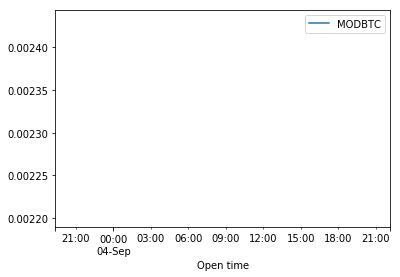

2018-09-11 00:00:00 2018-09-18 00:00:00
                         Open      High       Low     Close    Close time  \
Open time                                                                   
2018-09-11 00:00:00  0.000003  0.000003  0.000003  0.000003  1.536625e+12   
2018-09-11 00:15:00  0.000003  0.000003  0.000003  0.000003  1.536626e+12   
2018-09-11 00:30:00  0.000003  0.000003  0.000003  0.000003  1.536627e+12   
2018-09-11 00:45:00  0.000003  0.000003  0.000003  0.000003  1.536628e+12   
2018-09-11 01:00:00  0.000003  0.000003  0.000003  0.000003  1.536628e+12   
2018-09-11 01:15:00  0.000003  0.000003  0.000003  0.000003  1.536629e+12   
2018-09-11 01:30:00  0.000003  0.000003  0.000003  0.000003  1.536630e+12   
2018-09-11 01:45:00  0.000003  0.000003  0.000003  0.000003  1.536631e+12   
2018-09-11 02:00:00  0.000003  0.000003  0.000003  0.000003  1.536632e+12   
2018-09-11 02:15:00  0.000003  0.000003  0.000003  0.000003  1.536633e+12   

                      Volume       

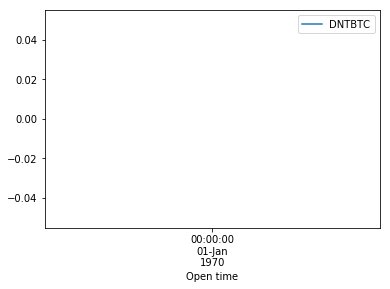

/home/me/bw-env/lib/python3.5/site-packages/ipykernel_launcher.py:62: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-09-18 00:00:00 2018-09-25 00:00:00
                         Open      High       Low     Close    Close time  \
Open time                                                                   
2018-09-18 00:00:00  0.003257  0.003267  0.003239  0.003249  1.537230e+12   
2018-09-18 00:15:00  0.003239  0.003259  0.003239  0.003243  1.537231e+12   
2018-09-18 00:30:00  0.003240  0.003252  0.003239  0.003246  1.537231e+12   
2018-09-18 00:45:00  0.003247  0.003251  0.003235  0.003236  1.537232e+12   
2018-09-18 01:00:00  0.003236  0.003246  0.003233  0.003233  1.537233e+12   
2018-09-18 01:15:00  0.003233  0.003243  0.003233  0.003235  1.537234e+12   
2018-09-18 01:30:00  0.003244  0.003244  0.003233  0.003233  1.537235e+12   
2018-09-18 01:45:00  0.003233  0.003243  0.003233  0.003233  1.537236e+12   
2018-09-18 02:00:00  0.003233  0.003244  0.003233  0.003242  1.537237e+12   
2018-09-18 02:15:00  0.003242  0.003265  0.003233  0.003262  1.537238e+12   

                     Volume     Std

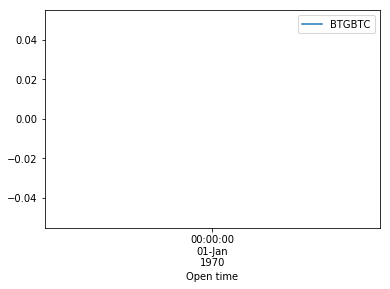

2018-09-25 00:00:00 2018-10-02 00:00:00


/home/me/bw-env/lib/python3.5/site-packages/ipykernel_launcher.py:62: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



                         Open      High       Low     Close    Close time  \
Open time                                                                   
2018-09-25 00:00:00  0.002493  0.002493  0.002490  0.002490  1.537834e+12   
2018-09-25 00:15:00  0.002490  0.002501  0.002490  0.002500  1.537835e+12   
2018-09-25 00:30:00  0.002492  0.002499  0.002490  0.002490  1.537836e+12   
2018-09-25 00:45:00  0.002490  0.002500  0.002490  0.002500  1.537837e+12   
2018-09-25 01:00:00  0.002493  0.002499  0.002490  0.002498  1.537838e+12   
2018-09-25 01:15:00  0.002491  0.002497  0.002489  0.002490  1.537839e+12   
2018-09-25 01:30:00  0.002489  0.002491  0.002489  0.002491  1.537840e+12   
2018-09-25 01:45:00  0.002491  0.002491  0.002491  0.002491  1.537841e+12   
2018-09-25 02:00:00  0.002491  0.002497  0.002490  0.002490  1.537842e+12   
2018-09-25 02:15:00  0.002493  0.002494  0.002490  0.002490  1.537843e+12   

                      Volume     Stdev  Moving Average  Criteria1  Criteria

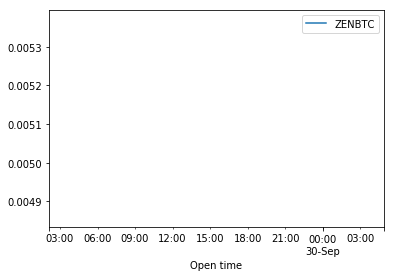

2018-10-02 00:00:00 2018-10-09 00:00:00


/home/me/bw-env/lib/python3.5/site-packages/ipykernel_launcher.py:62: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



                         Open      High       Low     Close    Close time  \
Open time                                                                   
2018-10-02 00:00:00  0.002594  0.002596  0.002581  0.002586  1.538439e+12   
2018-10-02 00:15:00  0.002589  0.002606  0.002587  0.002592  1.538440e+12   
2018-10-02 00:30:00  0.002600  0.002603  0.002562  0.002586  1.538441e+12   
2018-10-02 00:45:00  0.002585  0.002586  0.002562  0.002586  1.538442e+12   
2018-10-02 01:00:00  0.002573  0.002581  0.002558  0.002572  1.538443e+12   
2018-10-02 01:15:00  0.002575  0.002577  0.002546  0.002560  1.538444e+12   
2018-10-02 01:30:00  0.002560  0.002560  0.002559  0.002560  1.538445e+12   
2018-10-02 01:45:00  0.002560  0.002560  0.002543  0.002547  1.538446e+12   
2018-10-02 02:00:00  0.002544  0.002546  0.002540  0.002542  1.538446e+12   
2018-10-02 02:15:00  0.002546  0.002549  0.002529  0.002543  1.538447e+12   

                      Volume     Stdev  Moving Average  Criteria1  Criteria

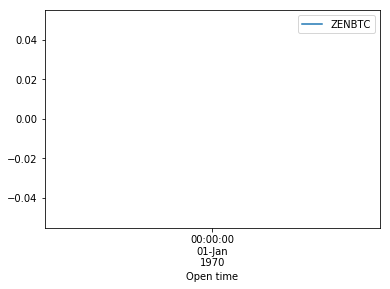

2018-10-09 00:00:00 2018-10-16 00:00:00


/home/me/bw-env/lib/python3.5/site-packages/ipykernel_launcher.py:62: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



                         Open      High       Low     Close    Close time  \
Open time                                                                   
2018-10-09 00:00:00  0.000184  0.000184  0.000183  0.000183  1.539044e+12   
2018-10-09 00:15:00  0.000184  0.000184  0.000183  0.000183  1.539045e+12   
2018-10-09 00:30:00  0.000183  0.000184  0.000183  0.000183  1.539046e+12   
2018-10-09 00:45:00  0.000183  0.000184  0.000183  0.000183  1.539047e+12   
2018-10-09 01:00:00  0.000183  0.000184  0.000183  0.000184  1.539048e+12   
2018-10-09 01:15:00  0.000184  0.000185  0.000184  0.000184  1.539049e+12   
2018-10-09 01:30:00  0.000184  0.000184  0.000183  0.000184  1.539049e+12   
2018-10-09 01:45:00  0.000184  0.000184  0.000183  0.000183  1.539050e+12   
2018-10-09 02:00:00  0.000183  0.000184  0.000183  0.000183  1.539051e+12   
2018-10-09 02:15:00  0.000183  0.000184  0.000182  0.000183  1.539052e+12   

                      Volume         Stdev  Moving Average  Criteria1  \
Op

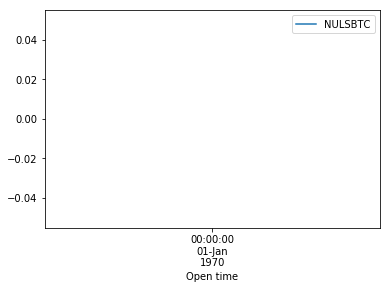

2018-10-16 00:00:00 2018-10-23 00:00:00


/home/me/bw-env/lib/python3.5/site-packages/ipykernel_launcher.py:62: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



                         Open      High       Low     Close    Close time  \
Open time                                                                   
2018-10-16 00:00:00  0.003995  0.004008  0.003993  0.003993  1.539649e+12   
2018-10-16 00:15:00  0.003996  0.004001  0.003993  0.003994  1.539650e+12   
2018-10-16 00:30:00  0.003993  0.003994  0.003978  0.003988  1.539651e+12   
2018-10-16 00:45:00  0.003988  0.004003  0.003983  0.003985  1.539652e+12   
2018-10-16 01:00:00  0.004000  0.004000  0.003979  0.003979  1.539652e+12   
2018-10-16 01:15:00  0.003979  0.003992  0.003973  0.003987  1.539653e+12   
2018-10-16 01:30:00  0.003976  0.004005  0.003975  0.003984  1.539654e+12   
2018-10-16 01:45:00  0.003991  0.003992  0.003972  0.003988  1.539655e+12   
2018-10-16 02:00:00  0.003989  0.003998  0.003980  0.003984  1.539656e+12   
2018-10-16 02:15:00  0.003985  0.003999  0.003982  0.003999  1.539657e+12   

                     Volume     Stdev  Moving Average  Criteria1  Criteria2

ValueError: ordinal must be >= 1

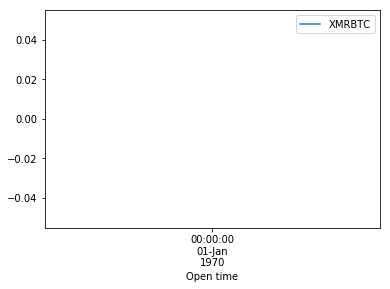

/home/me/bw-env/lib/python3.5/site-packages/ipykernel_launcher.py:62: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



2018-10-30 00:00:00 2018-11-06 00:00:00
                         Open      High       Low     Close    Close time  \
Open time                                                                   
2018-10-30 00:00:00  0.000186  0.000187  0.000186  0.000186  1.540858e+12   
2018-10-30 00:15:00  0.000186  0.000187  0.000186  0.000187  1.540859e+12   
2018-10-30 00:30:00  0.000186  0.000187  0.000185  0.000185  1.540860e+12   
2018-10-30 00:45:00  0.000185  0.000186  0.000184  0.000184  1.540861e+12   
2018-10-30 01:00:00  0.000185  0.000186  0.000184  0.000184  1.540862e+12   
2018-10-30 01:15:00  0.000184  0.000185  0.000184  0.000184  1.540863e+12   
2018-10-30 01:30:00  0.000184  0.000185  0.000184  0.000185  1.540864e+12   
2018-10-30 01:45:00  0.000185  0.000185  0.000183  0.000184  1.540865e+12   
2018-10-30 02:00:00  0.000185  0.000185  0.000184  0.000185  1.540866e+12   
2018-10-30 02:15:00  0.000185  0.000185  0.000184  0.000185  1.540867e+12   

                       Volume      

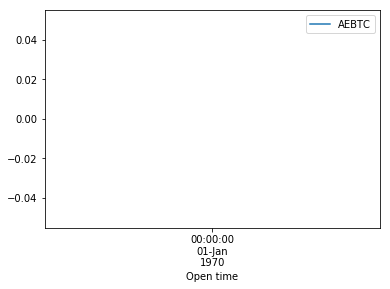

2018-11-06 00:00:00 2018-11-13 00:00:00


/home/me/bw-env/lib/python3.5/site-packages/ipykernel_launcher.py:62: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



                         Open      High       Low     Close    Close time  \
Open time                                                                   
2018-11-06 00:00:00  0.017433  0.017450  0.017430  0.017433  1.541463e+12   
2018-11-06 00:15:00  0.017446  0.017512  0.017432  0.017475  1.541464e+12   
2018-11-06 00:30:00  0.017475  0.017517  0.017475  0.017480  1.541465e+12   
2018-11-06 00:45:00  0.017480  0.017540  0.017480  0.017514  1.541466e+12   
2018-11-06 01:00:00  0.017514  0.017539  0.017468  0.017494  1.541467e+12   
2018-11-06 01:15:00  0.017494  0.017532  0.017494  0.017532  1.541468e+12   
2018-11-06 01:30:00  0.017532  0.017542  0.017499  0.017500  1.541469e+12   
2018-11-06 01:45:00  0.017500  0.017574  0.017500  0.017515  1.541470e+12   
2018-11-06 02:00:00  0.017553  0.017577  0.017503  0.017516  1.541470e+12   
2018-11-06 02:15:00  0.017517  0.017540  0.017485  0.017506  1.541471e+12   

                      Volume     Stdev  Moving Average  Criteria1  Criteria

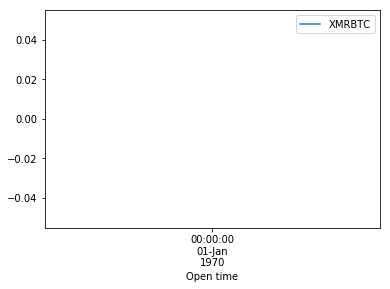

2018-11-13 00:00:00 2018-11-23 00:00:00


/home/me/bw-env/lib/python3.5/site-packages/ipykernel_launcher.py:62: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



                         Open      High       Low     Close    Close time  \
Open time                                                                   
2018-11-13 00:00:00  0.000219  0.000219  0.000211  0.000213  1.542068e+12   
2018-11-13 00:15:00  0.000213  0.000216  0.000211  0.000212  1.542069e+12   
2018-11-13 00:30:00  0.000212  0.000214  0.000212  0.000213  1.542070e+12   
2018-11-13 00:45:00  0.000213  0.000213  0.000212  0.000213  1.542071e+12   
2018-11-13 01:00:00  0.000213  0.000213  0.000209  0.000209  1.542072e+12   
2018-11-13 01:15:00  0.000209  0.000210  0.000207  0.000208  1.542073e+12   
2018-11-13 01:30:00  0.000208  0.000208  0.000206  0.000207  1.542073e+12   
2018-11-13 01:45:00  0.000206  0.000208  0.000206  0.000207  1.542074e+12   
2018-11-13 02:00:00  0.000207  0.000215  0.000206  0.000213  1.542075e+12   
2018-11-13 02:15:00  0.000213  0.000215  0.000209  0.000213  1.542076e+12   

                       Volume     Stdev  Moving Average  Criteria1  Criteri

ValueError: ordinal must be >= 1

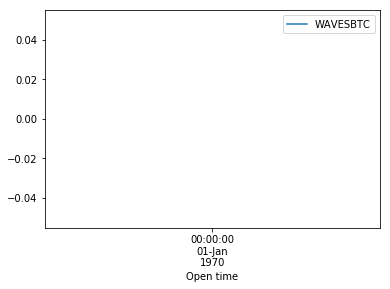

2018-11-30 00:00:00 2018-12-07 00:00:00


/home/me/bw-env/lib/python3.5/site-packages/ipykernel_launcher.py:62: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



                         Open      High       Low     Close    Close time  \
Open time                                                                   
2018-11-30 00:00:00  0.000011  0.000011  0.000011  0.000011  1.543537e+12   
2018-11-30 00:15:00  0.000011  0.000011  0.000011  0.000011  1.543538e+12   
2018-11-30 00:30:00  0.000011  0.000011  0.000011  0.000011  1.543539e+12   
2018-11-30 00:45:00  0.000011  0.000011  0.000011  0.000011  1.543540e+12   
2018-11-30 01:00:00  0.000011  0.000011  0.000011  0.000011  1.543540e+12   
2018-11-30 01:15:00  0.000011  0.000011  0.000011  0.000011  1.543541e+12   
2018-11-30 01:30:00  0.000011  0.000011  0.000011  0.000011  1.543542e+12   
2018-11-30 01:45:00  0.000011  0.000011  0.000011  0.000011  1.543543e+12   
2018-11-30 02:00:00  0.000011  0.000011  0.000011  0.000011  1.543544e+12   
2018-11-30 02:15:00  0.000011  0.000011  0.000011  0.000011  1.543545e+12   

                       Volume         Stdev  Moving Average  Criteria1  \
O

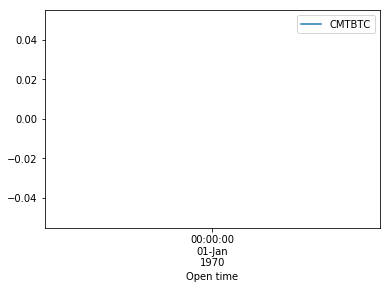

2018-12-07 00:00:00 2018-12-14 00:00:00


/home/me/bw-env/lib/python3.5/site-packages/ipykernel_launcher.py:62: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



                         Open      High       Low     Close    Close time  \
Open time                                                                   
2018-12-07 00:00:00  0.013231  0.013291  0.013110  0.013231  1.544142e+12   
2018-12-07 00:15:00  0.013232  0.013300  0.013174  0.013298  1.544143e+12   
2018-12-07 00:30:00  0.013298  0.013298  0.013241  0.013241  1.544143e+12   
2018-12-07 00:45:00  0.013250  0.013300  0.013222  0.013261  1.544144e+12   
2018-12-07 01:00:00  0.013261  0.013289  0.013211  0.013262  1.544145e+12   
2018-12-07 01:15:00  0.013233  0.013320  0.013213  0.013248  1.544146e+12   
2018-12-07 01:30:00  0.013217  0.013268  0.013211  0.013227  1.544147e+12   
2018-12-07 01:45:00  0.013212  0.013357  0.013211  0.013356  1.544148e+12   
2018-12-07 02:00:00  0.013357  0.013396  0.013325  0.013372  1.544149e+12   
2018-12-07 02:15:00  0.013387  0.013460  0.013366  0.013415  1.544150e+12   

                       Volume     Stdev  Moving Average  Criteria1  Criteri

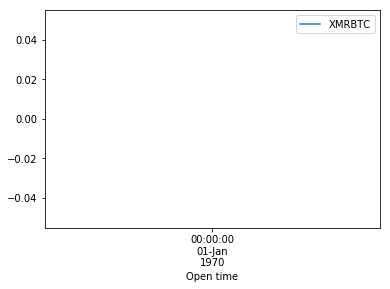

2018-12-14 00:00:00 2018-12-21 00:00:00


/home/me/bw-env/lib/python3.5/site-packages/ipykernel_launcher.py:62: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



                         Open      High       Low     Close    Close time  \
Open time                                                                   
2018-12-14 00:00:00  0.001338  0.001344  0.001329  0.001329  1.544746e+12   
2018-12-14 00:15:00  0.001335  0.001342  0.001331  0.001342  1.544747e+12   
2018-12-14 00:30:00  0.001334  0.001343  0.001333  0.001341  1.544748e+12   
2018-12-14 00:45:00  0.001340  0.001341  0.001340  0.001341  1.544749e+12   
2018-12-14 01:00:00  0.001339  0.001348  0.001339  0.001348  1.544750e+12   
2018-12-14 01:15:00  0.001340  0.001347  0.001340  0.001343  1.544751e+12   
2018-12-14 01:30:00  0.001345  0.001345  0.001340  0.001340  1.544752e+12   
2018-12-14 01:45:00  0.001340  0.001340  0.001340  0.001340  1.544753e+12   
2018-12-14 02:00:00  0.001340  0.001345  0.001338  0.001345  1.544754e+12   
2018-12-14 02:15:00  0.001345  0.001346  0.001345  0.001346  1.544755e+12   

                      Volume     Stdev  Moving Average  Criteria1  Criteria

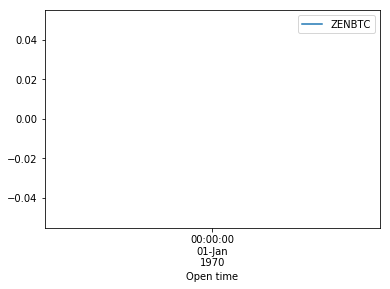

2018-12-21 00:00:00 2018-12-28 00:00:00


/home/me/bw-env/lib/python3.5/site-packages/ipykernel_launcher.py:62: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



                         Open      High       Low     Close    Close time  \
Open time                                                                   
2018-12-21 00:00:00  0.013368  0.013409  0.013331  0.013366  1.545351e+12   
2018-12-21 00:15:00  0.013366  0.013387  0.013280  0.013285  1.545352e+12   
2018-12-21 00:30:00  0.013283  0.013332  0.013201  0.013210  1.545353e+12   
2018-12-21 00:45:00  0.013214  0.013248  0.013188  0.013201  1.545354e+12   
2018-12-21 01:00:00  0.013201  0.013321  0.013188  0.013279  1.545355e+12   
2018-12-21 01:15:00  0.013280  0.013399  0.013208  0.013300  1.545356e+12   
2018-12-21 01:30:00  0.013300  0.013356  0.013300  0.013318  1.545357e+12   
2018-12-21 01:45:00  0.013317  0.013381  0.013300  0.013364  1.545358e+12   
2018-12-21 02:00:00  0.013365  0.013396  0.013130  0.013146  1.545358e+12   
2018-12-21 02:15:00  0.013147  0.013178  0.013088  0.013139  1.545359e+12   

                       Volume     Stdev  Moving Average  Criteria1  Criteri

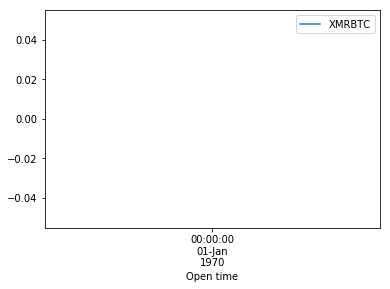

2018-12-28 00:00:00 2019-01-04 00:00:00


/home/me/bw-env/lib/python3.5/site-packages/ipykernel_launcher.py:62: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



                         Open      High       Low     Close    Close time  \
Open time                                                                   
2018-12-28 00:00:00  0.000212  0.000216  0.000211  0.000213  1.545956e+12   
2018-12-28 00:15:00  0.000213  0.000215  0.000212  0.000213  1.545957e+12   
2018-12-28 00:30:00  0.000213  0.000214  0.000211  0.000212  1.545958e+12   
2018-12-28 00:45:00  0.000212  0.000212  0.000212  0.000212  1.545959e+12   
2018-12-28 01:00:00  0.000212  0.000214  0.000209  0.000214  1.545960e+12   
2018-12-28 01:15:00  0.000214  0.000214  0.000211  0.000213  1.545961e+12   
2018-12-28 01:30:00  0.000213  0.000213  0.000210  0.000212  1.545961e+12   
2018-12-28 01:45:00  0.000212  0.000212  0.000210  0.000210  1.545962e+12   
2018-12-28 02:00:00  0.000211  0.000211  0.000209  0.000211  1.545963e+12   
2018-12-28 02:15:00  0.000211  0.000212  0.000209  0.000210  1.545964e+12   

                       Volume     Stdev  Moving Average  Criteria1  Criteri

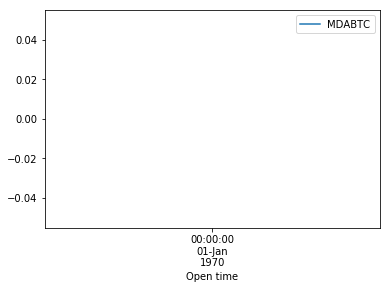

2019-01-04 00:00:00 2019-01-11 00:00:00


/home/me/bw-env/lib/python3.5/site-packages/ipykernel_launcher.py:62: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



                         Open      High       Low     Close    Close time  \
Open time                                                                   
2019-01-04 00:00:00  0.001421  0.001424  0.001418  0.001418  1.546561e+12   
2019-01-04 00:15:00  0.001418  0.001429  0.001418  0.001418  1.546562e+12   
2019-01-04 00:30:00  0.001428  0.001439  0.001426  0.001431  1.546563e+12   
2019-01-04 00:45:00  0.001436  0.001436  0.001426  0.001426  1.546564e+12   
2019-01-04 01:00:00  0.001437  0.001437  0.001427  0.001427  1.546564e+12   
2019-01-04 01:15:00  0.001437  0.001438  0.001434  0.001438  1.546565e+12   
2019-01-04 01:30:00  0.001435  0.001438  0.001430  0.001436  1.546566e+12   
2019-01-04 01:45:00  0.001436  0.001438  0.001436  0.001438  1.546567e+12   
2019-01-04 02:00:00  0.001432  0.001436  0.001432  0.001436  1.546568e+12   
2019-01-04 02:15:00  0.001436  0.001436  0.001427  0.001433  1.546569e+12   

                     Volume     Stdev  Moving Average  Criteria1  Criteria2

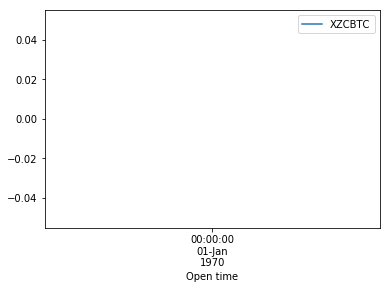

2019-01-11 00:00:00 2019-01-18 00:00:00


/home/me/bw-env/lib/python3.5/site-packages/ipykernel_launcher.py:62: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



                         Open      High       Low     Close    Close time  \
Open time                                                                   
2019-01-11 00:00:00  0.001382  0.001390  0.001382  0.001390  1.547166e+12   
2019-01-11 00:15:00  0.001389  0.001394  0.001382  0.001390  1.547167e+12   
2019-01-11 00:30:00  0.001391  0.001401  0.001391  0.001399  1.547167e+12   
2019-01-11 00:45:00  0.001399  0.001402  0.001398  0.001402  1.547168e+12   
2019-01-11 01:00:00  0.001399  0.001402  0.001398  0.001402  1.547169e+12   
2019-01-11 01:15:00  0.001398  0.001401  0.001398  0.001401  1.547170e+12   
2019-01-11 01:30:00  0.001402  0.001402  0.001398  0.001398  1.547171e+12   
2019-01-11 01:45:00  0.001401  0.001401  0.001398  0.001398  1.547172e+12   
2019-01-11 02:00:00  0.001398  0.001402  0.001398  0.001399  1.547173e+12   
2019-01-11 02:15:00  0.001402  0.001402  0.001394  0.001394  1.547174e+12   

                     Volume     Stdev  Moving Average  Criteria1  Criteria2

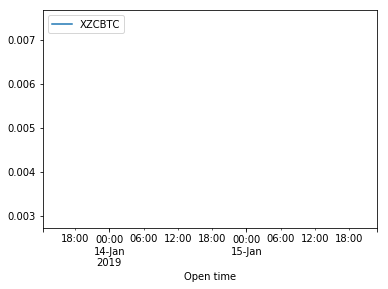

2019-01-18 00:00:00 2019-01-25 00:00:00


/home/me/bw-env/lib/python3.5/site-packages/ipykernel_launcher.py:62: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



                         Open      High       Low     Close    Close time  \
Open time                                                                   
2019-01-18 00:00:00  0.004116  0.004170  0.003996  0.004016  1.547770e+12   
2019-01-18 00:15:00  0.004016  0.004037  0.003936  0.003938  1.547771e+12   
2019-01-18 00:30:00  0.003939  0.003983  0.003937  0.003964  1.547772e+12   
2019-01-18 00:45:00  0.003953  0.004001  0.003953  0.003961  1.547773e+12   
2019-01-18 01:00:00  0.003961  0.004001  0.003952  0.003995  1.547774e+12   
2019-01-18 01:15:00  0.003986  0.004056  0.003986  0.003994  1.547775e+12   
2019-01-18 01:30:00  0.003993  0.004000  0.003840  0.003842  1.547776e+12   
2019-01-18 01:45:00  0.003850  0.003873  0.003769  0.003863  1.547777e+12   
2019-01-18 02:00:00  0.003862  0.003882  0.003814  0.003814  1.547778e+12   
2019-01-18 02:15:00  0.003819  0.003831  0.003697  0.003749  1.547779e+12   

                        Volume     Stdev  Moving Average  Criteria1  \
Open

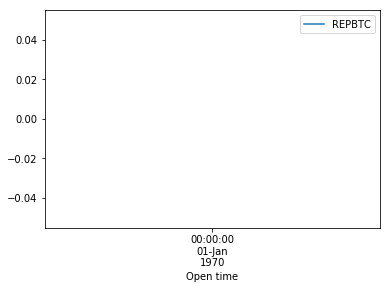

2019-01-25 00:00:00 2019-02-01 00:00:00


/home/me/bw-env/lib/python3.5/site-packages/ipykernel_launcher.py:62: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



                         Open      High       Low     Close    Close time  \
Open time                                                                   
2019-01-25 00:00:00  0.000013  0.000013  0.000013  0.000013  1.548375e+12   
2019-01-25 00:15:00  0.000013  0.000013  0.000013  0.000013  1.548376e+12   
2019-01-25 00:30:00  0.000013  0.000013  0.000013  0.000013  1.548377e+12   
2019-01-25 00:45:00  0.000013  0.000013  0.000013  0.000013  1.548378e+12   
2019-01-25 01:00:00  0.000013  0.000013  0.000013  0.000013  1.548379e+12   
2019-01-25 01:15:00  0.000013  0.000013  0.000013  0.000013  1.548380e+12   
2019-01-25 01:30:00  0.000013  0.000013  0.000013  0.000013  1.548381e+12   
2019-01-25 01:45:00  0.000013  0.000013  0.000013  0.000013  1.548382e+12   
2019-01-25 02:00:00  0.000013  0.000013  0.000013  0.000013  1.548382e+12   
2019-01-25 02:15:00  0.000013  0.000013  0.000013  0.000013  1.548383e+12   

                      Volume         Stdev  Moving Average  Criteria1  \
Op

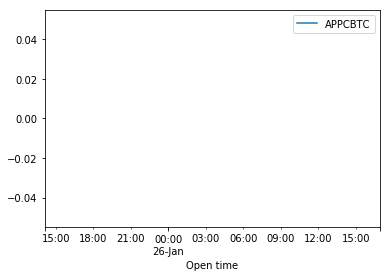

index 22 is out of bounds for axis 0 with size 22


/home/me/bw-env/lib/python3.5/site-packages/ipykernel_launcher.py:62: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,AEBTC,APPCBTC,BTGBTC,CMTBTC,DNTBTC,MDABTC,MODBTC,NULSBTC,REPBTC,WAVESBTC,XMRBTC,XZCBTC,ZENBTC
Open time,,,,,,,,,,,,,
2018-09-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-04 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-04 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-04 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-04 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-04 01:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-04 01:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-04 01:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-04 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
import ffn
p_dates = port.index.get_level_values('Date').drop_duplicates()
returns = []
all_ports = pd.DataFrame()
for c,d in enumerate(p_dates):
    if(c>len(p_dates)-1):
        break
    try:
        st = datetime.datetime.strptime(d, '%Y-%m-%d')
        end = datetime.datetime.strptime(p_dates[c+1], '%Y-%m-%d')
        print(st,end)
        
        st,end = int(unix_time_millis(st)),int(unix_time_millis(end))
        prev_st = st-86400000*intv
        curr_port = port.loc[d]
        p_coins = curr_port.index.get_level_values('Coin').values
        curr_port_hist = pd.DataFrame()
        for coin in p_coins:
            #current hist ...lazy way
            #c_hist = get_data(coin,st,end,candle_k='1h')
            #btc_hist = get_data('BTCUSDT',st,end,candle_k='1h')
            #q trader hist with prior data for training
            q_hist = get_data(coin,st,end,candle_k='15m')
            q_hist['Stdev'] = q_hist['Close'].rolling(window=9).std()
            q_hist['Moving Average'] = q_hist['Close'].rolling(window=12).mean()
            q_hist['Criteria1'] = (q_hist['Open'] - q_hist['Low'].shift(1)) < -q_hist['Stdev']
            q_hist['Criteria2'] = q_hist['Open'] > q_hist['Moving Average']
            q_hist['BUY'] = q_hist['Criteria1'] & q_hist['Criteria2']
            q_hist['Pct Change'] = (q_hist['Close'] - q_hist['Open']) / q_hist['Open']
            q_hist['Returns'] = q_hist['Pct Change'][q_hist['BUY'] == True]
            print(q_hist.head(10))
            curr_port_hist[coin] = q_hist['Returns']
            break
            
            
            #qb_hist = get_data('BTCUSDT',prev_st,end,candle_k='1h')
            """
            qt = QTrader(q_hist)
            print(qt.buy_and_hold(t_hist.index))
            #later replace with corr data
            midpoint = int(len(qt.returns.index) / 2)
            training_indexes = qt.returns.index[:midpoint] 
            testing_indexes = qt.returns.index[midpoint:]
            sym_trade = qt.q_holdings(training_indexes,testing_indexes)
            c_hist["btc returns"] = btc_hist['Close']#
            c_hist['sym_btc'] = c_hist["btc returns"]*c_hist['Close']
            c_hist['sym_btc'] = c_hist['sym_btc'].pct_change() 
            c_hist['Signal'] = sym_trade
            c_hist['cpct'] = c_hist['Close'].pct_change()
            c_hist['Market Returns'] = np.log(c_hist['Close'] / c_hist['Close'].shift(1))
            c_hist['Strategy'] = c_hist['sym_btc'] * c_hist['Signal']#.shift(1)
            #print(c_hist[[]].head(10))
            c_hist[['sym_btc','Strategy']].cumsum().plot(grid=True,figsize=(8,5))
            #c_hist[['Close','Signal']].plot(subplots=True,grid=True)
            #plt.show()
            """
            
          
        #perf = ffn.calc_stats(curr_port_hist)
        curr_port_hist.cumsum().plot()
        plt.show()
        all_ports = pd.concat([all_ports,curr_port_hist],axis=0)
        #print(curr_port_hist.head()) 
        #print(p_coins)
        
    except Exception as e:
        print(e)
        pass
all_ports
#all_ports= all_ports.fillna(0)
#all_ports.to_csv(fname+"all_coins.csv")


In [50]:
all_ports

AttributeError: 'DataFrame' object has no attribute 'dropnan'

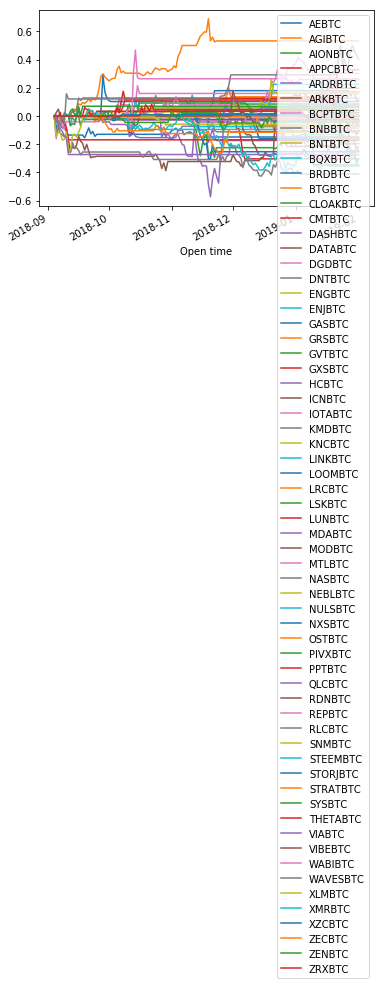

In [51]:
all_ports.fillna(0).cumsum().plot()